# Functions

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.mixture import GaussianMixture
import seaborn as sns
import wandb

In [2]:
def plot(x_1_labeled, x_2_labeled, x_unlabeled, W_OPT= np.ones(2)/np.sqrt(2), GAMMA=None , LIM=10):
  _, ax = plt.subplots(figsize=(10,10))
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(-LIM, LIM)
  ax.set_ylim(-LIM, LIM)


#   # opt & margin
#   _x = np.linspace(-LIM, LIM, 100)
#   _y = - W_OPT[0] * _x / W_OPT[1]
#   ax.plot(_x, _y, c='black')

  if GAMMA is not None:
      ax.plot(_x, _y + GAMMA, c='grey')
      ax.plot(_x, _y - GAMMA, c='grey')


  ax.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], marker='.', c='lightblue', s=5, label='unl')
  ax.scatter(x_1_labeled[:, 0],x_1_labeled[:, 1], marker='+', c='blue', s=20, label='0')
  ax.scatter(x_2_labeled[:, 0], x_2_labeled[:, 1], marker='_', c='red', s=20, label='1')
  plt.legend()
  return plt

In [3]:
def expectation_maximization_kmeans_init(x_unlabeled):
#     print(x_unlabeled[0], x_unlabeled.shape)
    gm = GaussianMixture(n_components=len(x_unlabeled[0]), random_state=0).fit(x_unlabeled)
    return gm.means_

In [4]:
def expectation_maximization_supervised_init(x_unlabeled=1000,x_1_labeled=10, x_2_labeled=10):
  mean_1 = np.mean(x_1_labeled, axis=0)
  mean_2 = np.mean(x_2_labeled, axis=0)
  means_init = np.append(mean_1[None, :], mean_2[None, :] ,axis=0)
  gm = GaussianMixture(n_components=2, random_state=0, means_init = means_init ).fit(x_unlabeled)
  return gm.means_

In [5]:
a = np.array([1, 2, 3, 4, 5])
a[:-2], a[-2:]

(array([1, 2, 3]), array([4, 5]))

In [6]:
def shuffle_data(A, b, enforce_constraint_on=None, seed=None):
    # If enforce_constrain_on is set, then make sure that we have samples from 
    # both classes in the first `enforce_constraint_on` samples.

    # idxs = None
    # while idxs is None or 
    #       (enforce_constraint_on is not None and 
    #        np.unique(b[idxs][:enforce_constraint_on]).shape[0] < 2):
    #   idxs = np.random.permutation(list(range(A.shape[0])))

    if seed is not None:
        np.random.seed(seed)
    idxs = np.random.permutation(list(range(A.shape[0])))
    A, b = A[idxs], b[idxs]
    if enforce_constraint_on is not None:
        # Ensure that the first `ensure_constraint_on` elements are half from one label, half from the other.
        labels = np.unique(b)
        neg_idxs = np.where((b == labels[0]))[0][:enforce_constraint_on // 2]
        pos_idxs = np.where((b == labels[1]))[0][:enforce_constraint_on // 2]
        first_idxs = np.concatenate((neg_idxs, pos_idxs))
        idxs = np.random.permutation(list(range(first_idxs.shape[0])))
        first_idxs = first_idxs[idxs]

        mask = np.ones(b.shape[0], dtype=bool)
        mask[neg_idxs] = False
        mask[pos_idxs] = False
        rest_A, rest_b = A[mask], b[mask]
        A = np.concatenate((A[first_idxs], rest_A))
        b = np.concatenate((b[first_idxs], rest_b))
    return A, b

def get_dataset(id_or_name, shuffle=True, test_ratio=0.2, balance_data=False):
    data = openml.datasets.get_dataset(id_or_name)
    X, y, _, _ = data.get_data(target=data.default_target_attribute)
    X, y = X.to_numpy(), y.to_numpy().astype(np.int)

    # Make all labels be -1 or 1.
    labels = list(np.sort(np.unique(y)))
    y[y == labels[0]] = -1
    y[y == labels[1]] = 1
#     assert list(np.sort(np.unique(y))) == [-1, 1], np.sort(np.unique(y))

    # Balance the two classes, by subsampling the majority class.
    if id_or_name != "mnist_784" and balance_data:
        X, y = shuffle_data(X, y)
        neg_idxs, pos_idxs = np.where(y == -1)[0], np.where(y == 1)[0]
        neg_size, pos_size = neg_idxs.shape[0], pos_idxs.shape[0]
        if neg_size < pos_size:
            idx = np.concatenate((neg_idxs, pos_idxs[:neg_size]))
        else:
            idx = np.concatenate((neg_idxs[:pos_size], pos_idxs))
        X, y = shuffle_data(X[idx], y[idx])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
    test_size = y_test.shape[0]
    X_train, X_val, y_train, y_val = X_train[:-test_size], X_train[-test_size:], y_train[:-test_size], y_train[-test_size:]
    
    assert test_size == X_val.shape[0]
    
    if shuffle:
        X_train, y_train = shuffle_data(X_train, y_train)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [7]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import openml
from sklearn.model_selection import train_test_split

# id_or_name = "mnist_784"
id_or_name = "vehicleNorm"

data = get_dataset(id_or_name, balance_data=True)

x, y = data[0], data[1]
scaler = preprocessing.StandardScaler()
if id_or_name == "mnist_784":
    class1=2
    class2=3
    x_subset=np.concatenate((x[y==class1],x[y==class2]) )
    x_scaled=scaler.fit_transform(x_subset)
    y_subset=np.concatenate((y[y==class1], y[y==class2]))
else:
    x_subset, y_subset=x, y
    x_scaled=scaler.fit_transform(x_subset)

/var/folders/n1/dtf3g85n7cgcs_h9gz0ygx3r0000gn/T/ipykernel_30852/1949607014.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, y = X.to_numpy(), y.to_numpy().astype(np.int)


In [8]:
pca=PCA(n_components=10)
x_trans=x_scaled#pca.fit_transform(x_scaled)
perm_idx=np.random.permutation(len(x_trans))
x_trans=x_trans[perm_idx]
y_subset=y_subset[perm_idx]

In [9]:
from sklearn.linear_model import LogisticRegression
def get_sup_estimator(x_labelled, y):
    clf = LogisticRegression(random_state=0, penalty='none').fit(x_labelled, y)
    return clf

In [10]:
from sklearn.linear_model import LogisticRegression
def get_unsup_estimator(x_unlabelled, x_test, y_test):
    em_means = expectation_maximization_kmeans_init(x_unlabelled)
    clf_em = LogisticRegression(random_state=0, penalty='none')
    clf_em.coef_=np.mean(em_means,axis=1).reshape(1,-1)
    clf_em.intercept_=0
    clf_em.classes_=np.unique(y_test)
    if clf_em.score(x_test, y_test) <0.5:
        clf_em.coef_*=-1
    return clf_em

In [11]:

# plt=plot(x_labelled[y==class1], 
#      x_labelled[y==class2], 
#      x_unlabelled, LIM=30)
# plt.scatter(x=np.mean(em_means[:,0]),y=np.mean(em_means[:,1]), s=52,c='g', )
# plt.scatter(x=clf.coef_[:,0],y=clf.coef_[:,1], marker='x', s=52,c='b', )


In [12]:

def get_ssl_estimator(clf_sl, clf_em, lambda_):
    clf_ssl = LogisticRegression(random_state=0, penalty='none')
    w=lambda_*clf_em.coef_ + (1-lambda_)*clf_sl.coef_
    w0=(1-lambda_)*clf_sl.intercept_

    clf_ssl.coef_=w
    clf_ssl.intercept_=w0
    clf_ssl.classes_=clf_sl.classes_
    return clf_ssl


In [16]:
def init_wandb_fn(params, goal_tag=None, debug=False):
    if debug:
        run = wandb.init(mode='disabled')
    else:
        run = wandb.init(project="ssl_lower_bound", entity="alext2", tags=[goal_tag] if goal_tag is not None else [],
                   # group=args.mode + '_nu2sign_init_' + str(args.init) + '_W_' + str(args.W),
                   settings=wandb.Settings(start_method="fork"))
    wandb.config.update(params)
    return run

In [228]:
n_unlabelled = 1000
n_repetition = 10

for n_rep in range(n_repetition):
    params = {
            "n_labeled": n_labelled,
            "n_unlabeled": n_unlabelled,
            "n_repetition": n_repetition,
            "dataset": id_or_name,
            "is_balanced": True,
            "n_train": data[0].shape[0],
            "n_val": data[2].shape[0],
            "n_test": data[4].shape[0],
            "d": data[0].shape[1],
            "log_file": "TODOTODO",
            "run_idx": n_rep,
        }
    run = init_wandb_fn(params)   

    x_trans, y_subset = scaler.fit_transform(data[0]), data[1]
    x_trans, y_subset = shuffle_data(x_trans, y_subset, seed=n_rep, enforce_constraint_on=n_labelled)

    for n_labelled in [10, 50, 100]:
        x_labelled=x_trans[0:n_labelled]
        x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
        y=y_subset[0:n_labelled]

        x_test, y_test = data[2], data[3]
        x_val, y_val = data[4], data[5]

        clf_sl=get_sup_estimator(x_labelled, y)
        clf_em=get_unsup_estimator(x_unlabelled, x_val, y_val)

        sl_error_val=1-clf_sl.score(x_val, y_val)
        ul_error_val=1-clf_em.score(x_val, y_val)

        sl_error_test=1-clf_sl.score(x_test, y_test)
        ul_error_test=1-clf_em.score(x_test, y_test)

        score_arr=[]
        all_lambdas = np.linspace(0,1,20)
        for lambda_ in all_lambdas:
            clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
            score_arr.append(clf_ssl.score(x_val, y_val))
        best_lambda = all_lambdas[np.argmax(score_arr)]
        best_clf_ssl=get_ssl_estimator(clf_sl, clf_em, best_lambda)

        ssl_error_val=1-best_clf_ssl.score(x_val, y_val)
        ssl_error_test=1-best_clf_ssl.score(x_test, y_test)  

        metrics = {
            "sl_val_error": sl_error_val,
            "ssl_val_error": ssl_error_val,
            "ul_val_error": ul_error_val,
            "sl_test_error": sl_error_test,
            "ssl_test_error": ssl_error_test,
            "ul_test_error": ul_error_test,
            "sl_vs_ssl_gap_test": sl_error_test - ssl_error_test,
            "sl_vs_ssl_gap_val": sl_error_val - ssl_error_val,
            "ul_vs_ssl_gap_val": ul_error_val - ssl_error_val,
            "ul_vs_ssl_gap_test": ul_error_test - ssl_error_test,
            "best_lambda": best_lambda,
        }
        wandb.log(metrics, commit=False)
        wandb.log({"n_labeled": n_labelled})
        
        print(n_labelled, sl_error_val, ssl_error_val, ul_error_val)

    run.finish()

10 0.3804932507865625 0.3327920430325789 0.4704658479650867
50 0.363087384552928 0.363087384552928 0.48949558510098445
100 0.29295645996143305 0.2929057139957374 0.4340809905612504


best_lambda,█▁▂
n_labeled,▁▄█
sl_test_error,█▇▁
sl_val_error,█▇▁
sl_vs_ssl_gap_test,█▁▁
sl_vs_ssl_gap_val,█▁▁
ssl_test_error,▅█▁
ssl_val_error,▅█▁
ul_test_error,▆█▁
ul_val_error,▆█▁
ul_vs_ssl_gap_test,▇▁█


10 0.43387800669846743 0.31010859636658883 0.4919821374200751
50 0.2538820663757231 0.2538820663757231 0.4651375215670355
100 0.2797117629148482 0.26966406170709434 0.46260022328224903


best_lambda,▆▁█
n_labeled,▁▄█
sl_test_error,█▁▂
sl_val_error,█▁▂
sl_vs_ssl_gap_test,█▁▁
sl_vs_ssl_gap_val,█▁▂
ssl_test_error,█▁▃
ssl_val_error,█▁▃
ul_test_error,█▂▁
ul_val_error,█▂▁
ul_vs_ssl_gap_test,▁█▃


10 0.4640718562874252 0.4640718562874252 0.4872120166446767
50 0.3663351263574546 0.3663351263574546 0.49609256064142904
100 0.4053587739774688 0.40485131432051147 0.47467776311783216


best_lambda,▁▁█
n_labeled,▁▄█
sl_test_error,█▁▄
sl_val_error,█▁▄
sl_vs_ssl_gap_test,██▁
sl_vs_ssl_gap_val,▁▁█
ssl_test_error,█▁▄
ssl_val_error,█▁▄
ul_test_error,▅█▁
ul_val_error,▅█▁
ul_vs_ssl_gap_test,▁█▄


10 0.2986907540850502 0.2986907540850502 0.48152846848675535
50 0.29118035116208263 0.24748807469806156 0.3942454074901045
100 0.35887546940018267 0.33324875672384047 0.4779762508880544


best_lambda,▁██
n_labeled,▁▄█
sl_test_error,▁▁█
sl_val_error,▂▁█
sl_vs_ssl_gap_test,▁█▄
sl_vs_ssl_gap_val,▁█▅
ssl_test_error,▅▁█
ssl_val_error,▅▁█
ul_test_error,█▁█
ul_val_error,█▁█
ul_vs_ssl_gap_test,█▂▁


10 0.3722216583781589 0.31127575357759063 0.46630467877803716
50 0.3939916776616259 0.34755911905003556 0.4811732467268852
100 0.39536181873541054 0.39470212118136605 0.4669136303663859


best_lambda,▁▆█
n_labeled,▁▄█
sl_test_error,▁▆█
sl_val_error,▁██
sl_vs_ssl_gap_test,█▆▁
sl_vs_ssl_gap_val,█▆▁
ssl_test_error,▁▄█
ssl_val_error,▁▄█
ul_test_error,▂█▁
ul_val_error,▁█▁
ul_vs_ssl_gap_test,█▆▁


10 0.4294123617172435 0.4294123617172435 0.4804120572414493
50 0.3500456713691261 0.3500456713691261 0.4873642545417639
100 0.35699786866944083 0.35699786866944083 0.474525525220745


best_lambda,▁▁▁
n_labeled,▁▄█
sl_test_error,█▁▁
sl_val_error,█▁▂
sl_vs_ssl_gap_test,▁▁▁
sl_vs_ssl_gap_val,▁▁▁
ssl_test_error,█▁▁
ssl_val_error,█▁▂
ul_test_error,▇█▁
ul_val_error,▄█▁
ul_vs_ssl_gap_test,▁█▆


10 0.4143408099056125 0.4143408099056125 0.4934030244595554
50 0.34629046990764234 0.34629046990764234 0.44478838932304887
100 0.3883081295037044 0.38800365370953005 0.49944179437734704


best_lambda,▁▁█
n_labeled,▁▄█
sl_test_error,█▁▆
sl_val_error,█▁▅
sl_vs_ssl_gap_test,██▁
sl_vs_ssl_gap_val,▁▁█
ssl_test_error,█▁▆
ssl_val_error,█▁▅
ul_test_error,▇▁█
ul_val_error,▇▁█
ul_vs_ssl_gap_test,▁▄█


10 0.43773470009134274 0.43773470009134274 0.4940627220135999
50 0.2976758347711357 0.25479549375824617 0.43707500253729825
100 0.2623566426469096 0.2610879935045164 0.49517913325890595


best_lambda,▁█▇
n_labeled,▁▄█
sl_test_error,█▂▁
sl_val_error,█▂▁
sl_vs_ssl_gap_test,▁█▁
sl_vs_ssl_gap_val,▁█▁
ssl_test_error,█▁▁
ssl_val_error,█▁▁
ul_test_error,█▁█
ul_val_error,█▁█
ul_vs_ssl_gap_test,▁▆█


10 0.4151527453567442 0.3270577489089618 0.4186034710240536
50 0.3833350248655232 0.32964579315944387 0.48964782299807164
100 0.3646605094894956 0.32989952298792247 0.4991880645488683


best_lambda,▁▁█
n_labeled,▁▄█
sl_test_error,█▃▁
sl_val_error,█▄▁
sl_vs_ssl_gap_test,█▄▁
sl_vs_ssl_gap_val,█▃▁
ssl_test_error,▅▁█
ssl_val_error,▁▇█
ul_test_error,▁▇█
ul_val_error,▁▇█
ul_vs_ssl_gap_test,▁██


10 0.3637470821069725 0.36263067086166645 0.43798842991982134
50 0.36958286816198116 0.33801887749923876 0.4973104638181265
100 0.2887952907743835 0.2885415609459048 0.4704658479650867


best_lambda,▂█▁
n_labeled,▁▄█
sl_test_error,██▁
sl_val_error,▇█▁
sl_vs_ssl_gap_test,▂█▁
sl_vs_ssl_gap_val,▁█▁
ssl_test_error,█▆▁
ssl_val_error,█▆▁
ul_test_error,▁█▅
ul_val_error,▁█▅
ul_vs_ssl_gap_test,▁▆█


Text(0, 0.5, 'Accuracy')

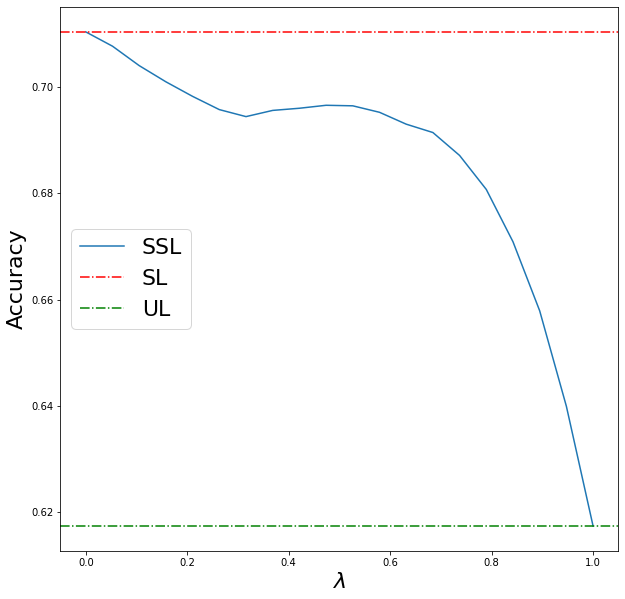

In [218]:
n_labelled=50000
n_unlabelled=100

x_trans, y_subset = scaler.fit_transform(data[0]), data[1]
x_trans, y_subset = shuffle_data(x_trans, y_subset, seed=0, enforce_constraint_on=n_labelled)

x_labelled=x_trans[0:n_labelled]
x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
y=y_subset[0:n_labelled]

x_test=x_trans[n_labelled+n_unlabelled:]
y_test=y_subset[n_labelled+n_unlabelled:]



plt.figure(figsize=(10,10))
clf_sl=get_sup_estimator(x_labelled, y)
clf_em=get_unsup_estimator(x_unlabelled, x_val, y_val)

sl_score=clf_sl.score(x_val, y_val)
ul_score=clf_em.score(x_val, y_val)

score_arr=[]
for lambda_ in np.linspace(0,1,20):
    clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
    score_arr.append(clf_ssl.score(x_val, y_val))

plt.plot(np.linspace(0,1,20), score_arr, label='SSL')
plt.axhline(sl_score, label='SL', color='r', linestyle='-.',)
plt.axhline(ul_score, label='UL', linestyle='-.', color='g')
plt.legend(fontsize=22)
plt.xlabel('$\lambda$', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)

In [17]:
from tqdm import tqdm
def get_best_lambda(clf_sl, clf_em, x_test, y_test):    
    score_arr=[]
    best_lambda=0
    best_score=0
    for lambda_ in np.linspace(0,1,100):
        clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
        score_curr = clf_ssl.score(x_test, y_test)
        if score_curr > best_score:
            best_lambda=lambda_
            best_score = score_curr
    return best_lambda, best_score

In [18]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
from sklearn.datasets import fetch_openml


def get_classes(x,y, class1=2, class2=3):
    scaler = preprocessing.StandardScaler()
    # class1=2
    # class2=3
    pca=PCA(n_components=2)
    x_subset=np.concatenate((x[y==class1],x[y==class2]) )
    x_scaled=scaler.fit_transform(x_subset)
    x_trans=pca.fit_transform(x_scaled)
    y_subset=np.concatenate((y[y==class1], y[y==class2]))
    perm_idx=np.random.permutation(len(x_trans))
    x_trans=x_trans[perm_idx]
    y_subset=y_subset[perm_idx]
    return x_trans, y_subset




Text(0, 0.5, '$\\lambda$')

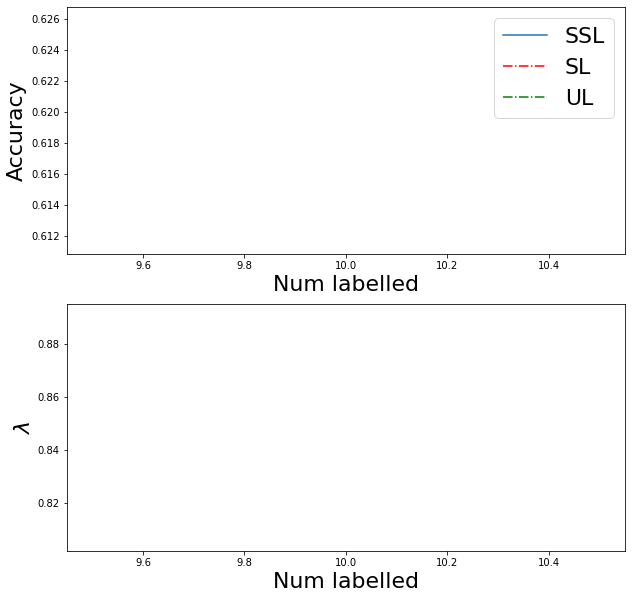

In [19]:

fig,ax=plt.subplots(2,1,figsize=(10,10))
n_labelled_arr=[10]#np.arange(4,20, 2)
n_unlabelled_arr=[2000]


x_test=x_trans[n_labelled_arr[-1]+n_unlabelled_arr[-1]:]
y_test=y_subset[n_labelled_arr[-1]+n_unlabelled_arr[-1]:]

ssl_arr=[]
lambda_arr=[]
sl_arr=[]
ul_arr=[]
for n_labelled in n_labelled_arr:
    for n_unlabelled in n_unlabelled_arr:
        x_labelled=x_trans[0:n_labelled]
        x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
        y=y_subset[0:n_labelled]



        clf_sl=get_sup_estimator(x_labelled, y)
        clf_em=get_unsup_estimator(x_unlabelled, x_test, y_test)
        sl_score=clf_sl.score(x_test, y_test)
        ul_score=clf_em.score(x_test, y_test)
        best_lambda, ssl_score = get_best_lambda(clf_sl, clf_em, x_test, y_test)
        ssl_arr.append(ssl_score)
        lambda_arr.append(best_lambda)
        sl_arr.append(sl_score)
        ul_arr.append(ul_score)
        
        
ax[0].plot(n_labelled_arr, ssl_arr, label='SSL')
ax[0].plot(n_labelled_arr, sl_arr, label='SL', color='r', linestyle='-.',)
ax[0].plot(n_labelled_arr, ul_arr, label='UL', linestyle='-.', color='g')
ax[0].legend(fontsize=22)
ax[0].set_xlabel('Num labelled', fontsize=22)
ax[0].set_ylabel('Accuracy', fontsize=22)

ax[1].plot(n_labelled_arr, lambda_arr, linestyle='-', color='k')
ax[1].set_xlabel('Num labelled', fontsize=22)
ax[1].set_ylabel('$\lambda$', fontsize=22)



In [21]:
# mnist = fetch_openml('mnist_784')
data = openml.datasets.get_dataset('mnist_784')
x_all, y_all, _, _ = data.get_data(target=data.default_target_attribute)
# x_all = mnist.data.to_numpy()
# y_all = mnist.target.to_numpy(dtype='int')

In [22]:
print(x_all.shape,y_all.shape)

(70000, 784) (70000,)


In [25]:
n_labelled=100
n_unlabelled=2000
num_exps=5
class1_arrs=[[] for _ in range(num_exps)]
class2_arrs=[[] for _ in range(num_exps)]
ssl_arrs=[[] for _ in range(num_exps)]
lambda_arrs=[[] for _ in range(num_exps)]
sl_arrs=[[] for _ in range(num_exps)]
ul_arrs=[[] for _ in range(num_exps)]
margin_arrs=[[] for _ in range(num_exps)]
from sklearn.svm import LinearSVC


for idx in tqdm(range(num_exps)):    
    class1_arr=class1_arrs[idx]
    class2_arr=class2_arrs[idx]
    ssl_arr=ssl_arrs[idx]
    lambda_arr=lambda_arrs[idx]
    sl_arr=sl_arrs[idx]
    ul_arr=ul_arrs[idx]
    margin_arr=margin_arrs[idx]
    for class1 in np.arange(0,10):
        for class2 in range(class1+1, 10):
            while True:
                x_trans,y_subset= get_classes(x_all,y_all, class1=class1, class2=class2)

                x_labelled=x_trans[0:n_labelled]
                x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
                y=y_subset[0:n_labelled]
                if class1 in y and class2 in y:
                    break


            x_test=x_trans[n_labelled:]
            y_test=y_subset[n_labelled:]
#             svc=LinearSVC(C=10^5)
#             svc.fit(x_test, y_test)
#             margin_=1./np.linalg.norm(svc.coef_)

#     #         if margin_ > 3:
#     #             continue
#             margin_arr.append(margin_)
            class1_arr.append(class1)
            class2_arr.append(class2)





            clf_sl=get_sup_estimator(x_labelled, y)
            clf_em=get_unsup_estimator(x_unlabelled, x_test, y_test)
            sl_score=clf_sl.score(x_test, y_test)
            ul_score=clf_em.score(x_test, y_test)
            best_lambda, ssl_score = get_best_lambda(clf_sl, clf_em, x_test, y_test)
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            sl_arr.append(sl_score)
            ul_arr.append(ul_score)


class1_arrs=np.mean(class1_arrs, axis=0)
class2_arrs=np.mean(class2_arrs, axis=0)
ssl_arrs=np.mean(ssl_arrs, axis=0)
lambda_arrs=np.mean(lambda_arrs, axis=0)
sl_arrs=np.mean(sl_arrs, axis=0)
ul_arrs=np.mean(ul_arrs, axis=0)
margin_arrs=np.mean(margin_arrs, axis=0)

  0%|                                                                          | 0/5 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 784)) while a minimum of 1 is required by StandardScaler.

Text(0, 0.5, '$\\lambda$')

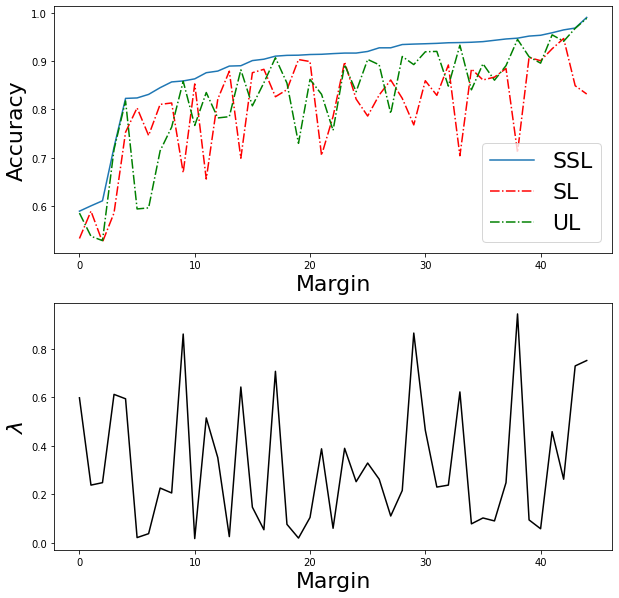

In [49]:
fig,ax=plt.subplots(2,1,figsize=(10,10)) 
def sort_with(arr_, idx_):
    return [arr_[i] for i in idx_]
sort_idx=np.argsort(ssl_arrs)
ax[0].plot(sort_with(ssl_arrs, sort_idx), 
           label='SSL')
ax[0].plot(sort_with(sl_arrs, sort_idx), 
           label='SL', color='r', linestyle='-.',)
ax[0].plot(sort_with(ul_arrs, sort_idx), 
           label='UL', linestyle='-.', color='g')
# ax[0].set_ylim(0.8,1)
ax[0].legend(fontsize=22)
ax[0].set_xlabel('Margin', fontsize=22)
ax[0].set_ylabel('Accuracy', fontsize=22)
ax[1].plot(sort_with(lambda_arrs, sort_idx),
           linestyle='-', color='k')
ax[1].set_xlabel('Margin', fontsize=22)
ax[1].set_ylabel('$\lambda$', fontsize=22)